# PM2.5 Air Quality Analysis: Modular Python Implementation

This notebook demonstrates my implementation of a modular Python analysis framework for PM2.5 air quality data across six major U.S. cities. The project is organized into reusable modules that handle data loading, statistical analysis, extreme event detection, and trend analysis.

## Project Structure

The codebase includes:
- **`air_quality.data_loader`** - Functions for loading and filtering PM2.5 data
- **`air_quality.statistics`** - Statistical computations (means, rolling averages, exceedances, AQI)
- **`air_quality.extremes`** - Extreme value identification methods
- **`air_quality.trends`** - Temporal pattern and trend analysis
- **`scripts/`** - Standalone plotting scripts for generating publication-quality figures

The data covers daily PM2.5 measurements for 2024 from Los Angeles, Fresno, Phoenix, Denver, Salt Lake City, and Pittsburgh.

## Setup and Data Loading

I'll start by importing the necessary modules and loading the dataset:

In [627]:
import pandas as pd
import numpy as np
import sys
import os
from IPython.display import Image, display

# Import the analysis modules
from air_quality.statistics import (
    calculate_daily_mean,
    calculate_rolling_average,
    calculate_exceedance_count,
    calculate_aqi
)
from air_quality.extremes import (
    identify_extremes_threshold,
    identify_extremes_percentile,
    identify_consecutive_exceedances
)
from air_quality.data_loader import (
    load_pm25_data,
    filter_by_city,
    get_cities_list
)
from air_quality.trends import (
    calculate_linear_trend,
    calculate_seasonal_average,
    calculate_monthly_statistics
)

# Load the dataset
df = load_pm25_data('data/all_cities_pm25.csv')
print(f"Loaded {len(df)} observations")
print(f"Cities: {get_cities_list(df)}")
print(f"\nFirst few records:")
print(df.head())

Loaded 2196 observations
Cities: ['Denver', 'Fresno', 'Los Angeles', 'Phoenix', 'Pittsburgh', 'Salt Lake City']

First few records:
        date         city pollutant      value
0 2024-01-01  Los Angeles     PM2.5  22.445674
1 2024-01-02  Los Angeles     PM2.5  13.680909
2 2024-01-03  Los Angeles     PM2.5   8.141040
3 2024-01-04  Los Angeles     PM2.5   6.034635
4 2024-01-05  Los Angeles     PM2.5  11.618910


## Part 1: Statistical Analysis Functions

### Daily Mean Calculation

The `calculate_daily_mean()` function computes the mean of PM2.5 values using NumPy. I'll demonstrate this by comparing the annual average PM2.5 levels across cities:

In [628]:
print("Annual Average PM2.5 by City (2024)")
print("=" * 50)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city)
    annual_mean = calculate_daily_mean(city_data['value'].values)
    print(f"{city:20s}: {annual_mean:6.2f} μg/m³")

print("\nEPA Annual Standard: 9.0 μg/m³")
print("EPA 24-hour Standard: 35 μg/m³")

Annual Average PM2.5 by City (2024)
Denver              :   6.64 μg/m³
Fresno              :  10.03 μg/m³
Los Angeles         :  10.87 μg/m³
Phoenix             :   8.55 μg/m³
Pittsburgh          :   7.73 μg/m³
Salt Lake City      :   7.16 μg/m³

EPA Annual Standard: 9.0 μg/m³
EPA 24-hour Standard: 35 μg/m³


### Rolling Average Analysis

Rolling averages help smooth out day-to-day variability. The `calculate_rolling_average()` function computes a moving average with a specified window size. Here's an example using Los Angeles data with a 7-day window:

In [629]:
# Get Los Angeles data
la_data = filter_by_city(df, 'Los Angeles').sort_values('date')
la_values = la_data['value'].values

# Calculate 7-day rolling average
rolling_7day = calculate_rolling_average(la_values, window=7)

# Show first 10 days
print("Los Angeles - First 10 Days:")
print("Date       | Daily PM2.5 | 7-Day Average")
print("-" * 50)
for i in range(10):
    date = la_data.iloc[i]['date'].strftime('%Y-%m-%d')
    daily = la_values[i]
    rolling = rolling_7day[i]
    if np.isnan(rolling):
        print(f"{date} | {daily:11.2f} | {'N/A':>13}")
    else:
        print(f"{date} | {daily:11.2f} | {rolling:13.2f}")

Los Angeles - First 10 Days:
Date       | Daily PM2.5 | 7-Day Average
--------------------------------------------------
2024-01-01 |       22.45 |           N/A
2024-01-02 |       13.68 |           N/A
2024-01-03 |        8.14 |           N/A
2024-01-04 |        6.03 |           N/A
2024-01-05 |       11.62 |           N/A
2024-01-06 |       12.78 |           N/A
2024-01-07 |        2.92 |         11.09
2024-01-08 |        6.80 |          8.85
2024-01-09 |       11.12 |          8.49
2024-01-10 |       11.87 |          9.02


### Exceedance Counting

The `calculate_exceedance_count()` function counts how many days exceed a given threshold. This is useful for assessing compliance with air quality standards. The EPA 24-hour standard is 35 μg/m³:

In [630]:
epa_threshold = 35.0

print(f"Days Exceeding EPA 24-hour Standard ({epa_threshold} μg/m³)")
print("=" * 50)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city)
    exceedance_days = calculate_exceedance_count(city_data['value'].values, epa_threshold)
    total_days = len(city_data)
    percentage = (exceedance_days / total_days) * 100
    
    print(f"{city:20s}: {exceedance_days:3d} days ({percentage:5.1f}%)")

Days Exceeding EPA 24-hour Standard (35.0 μg/m³)
Denver              :   0 days (  0.0%)
Fresno              :   6 days (  1.6%)
Los Angeles         :   3 days (  0.8%)
Phoenix             :   2 days (  0.5%)
Pittsburgh          :   0 days (  0.0%)
Salt Lake City      :   1 days (  0.3%)


### Air Quality Index (AQI) Calculation

The `calculate_aqi()` function converts PM2.5 concentrations into the EPA Air Quality Index, which provides health-based categories. Let me demonstrate this with the highest PM2.5 day for each city:

In [631]:
print("AQI for Highest PM2.5 Days by City:")
print("=" * 70)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city)
    max_row = city_data.loc[city_data['value'].idxmax()]
    pm25 = max_row['value']
    date = max_row['date'].strftime('%Y-%m-%d')
    
    aqi_info = calculate_aqi(pm25)
    
    print(f"{city:20s} ({date}):")
    print(f"  PM2.5: {pm25:6.2f} μg/m³")
    print(f"  AQI: {aqi_info['aqi']:3d} - {aqi_info['category']}")
    print(f"  {aqi_info['health_message']}")
    print()

AQI for Highest PM2.5 Days by City:
Denver               (2024-07-23):
  PM2.5:  26.41 μg/m³
  AQI:  81 - Moderate
  Acceptable for most, but sensitive groups may be affected.

Fresno               (2024-12-06):
  PM2.5:  46.02 μg/m³
  AQI: 127 - Unhealthy for Sensitive Groups
  Sensitive groups may experience health effects.

Los Angeles          (2024-07-05):
  PM2.5:  40.26 μg/m³
  AQI: 113 - Unhealthy for Sensitive Groups
  Sensitive groups may experience health effects.

Phoenix              (2024-01-01):
  PM2.5:  79.04 μg/m³
  AQI: 163 - Unhealthy
  Everyone may begin to experience health effects.

Pittsburgh           (2024-08-15):
  PM2.5:  21.99 μg/m³
  AQI:  72 - Moderate
  Acceptable for most, but sensitive groups may be affected.

Salt Lake City       (2024-09-11):
  PM2.5:  36.16 μg/m³
  AQI: 103 - Unhealthy for Sensitive Groups
  Sensitive groups may experience health effects.



## Part 2: Extreme Event Detection

### Threshold-Based Detection

The `identify_extremes_threshold()` function identifies days exceeding a specific PM2.5 concentration. I'll use the unhealthy threshold of 55.4 μg/m³:

In [632]:
unhealthy_threshold = 55.4

print(f"Extreme Events (PM2.5 > {unhealthy_threshold} μg/m³)")
print("=" * 70)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city).copy()
    city_data = city_data.rename(columns={'date': 'Date', 'value': 'PM2.5'})
    
    extremes = identify_extremes_threshold(city_data, unhealthy_threshold)
    
    if len(extremes) > 0:
        print(f"\n{city}: {len(extremes)} extreme days")
        print("  Top 3 worst days:")
        for i, row in extremes.head(3).iterrows():
            date = row['Date'].strftime('%Y-%m-%d')
            pm25 = row['PM2.5']
            print(f"    {date}: {pm25:6.2f} μg/m³")
    else:
        print(f"\n{city}: No extreme events")

Extreme Events (PM2.5 > 55.4 μg/m³)

Denver: No extreme events

Fresno: No extreme events

Los Angeles: No extreme events

Phoenix: 1 extreme days
  Top 3 worst days:
    2024-01-01:  79.04 μg/m³

Pittsburgh: No extreme events

Salt Lake City: No extreme events


### Percentile-Based Detection

Sometimes it's useful to identify extreme days relative to typical conditions rather than absolute thresholds. The `identify_extremes_percentile()` function finds days above a given percentile:

In [633]:
percentile = 95

print(f"Extreme Events (Above {percentile}th Percentile)")
print("=" * 70)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city).copy()
    city_data = city_data.rename(columns={'date': 'Date', 'value': 'PM2.5'})
    
    extremes = identify_extremes_percentile(city_data, percentile)
    
    if len(extremes) > 0:
        threshold = extremes['PM2.5'].min()
        print(f"\n{city}:")
        print(f"  Threshold: {threshold:.2f} μg/m³")
        print(f"  Count: {len(extremes)} days")
    else:
        print(f"\n{city}: No extreme events found")

Extreme Events (Above 95th Percentile)

Denver:
  Threshold: 14.14 μg/m³
  Count: 19 days

Fresno:
  Threshold: 18.77 μg/m³
  Count: 19 days

Los Angeles:
  Threshold: 20.28 μg/m³
  Count: 19 days

Phoenix:
  Threshold: 18.39 μg/m³
  Count: 19 days

Pittsburgh:
  Threshold: 14.53 μg/m³
  Count: 19 days

Salt Lake City:
  Threshold: 19.21 μg/m³
  Count: 19 days


### Consecutive Exceedance Analysis

Multi-day pollution episodes can be particularly harmful. The `identify_consecutive_exceedances()` function finds sequences of consecutive days above a threshold:

In [634]:
threshold = 35.0

print(f"Consecutive Exceedance Episodes (Threshold: {threshold} μg/m³)")
print("=" * 80)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city).copy()
    city_data = city_data.rename(columns={'date': 'Date', 'value': 'PM2.5'})
    
    episodes = identify_consecutive_exceedances(city_data, threshold)
    
    if len(episodes) > 0:
        longest = episodes.iloc[0]
        print(f"\n{city}: {len(episodes)} episodes")
        print(f"  Longest episode: {longest['duration']} days")
        print(f"    {longest['start_date'].strftime('%Y-%m-%d')} to {longest['end_date'].strftime('%Y-%m-%d')}")
        print(f"    Peak: {longest['max_pm25']:.2f} μg/m³, Average: {longest['mean_pm25']:.2f} μg/m³")
    else:
        print(f"\n{city}: No consecutive exceedance episodes")

Consecutive Exceedance Episodes (Threshold: 35.0 μg/m³)

Denver: No consecutive exceedance episodes

Fresno: 1 episodes
  Longest episode: 6 days
    2024-12-03 to 2024-12-08
    Peak: 46.02 μg/m³, Average: 40.99 μg/m³

Los Angeles: 3 episodes
  Longest episode: 1 days
    2024-07-05 to 2024-07-05
    Peak: 40.26 μg/m³, Average: 40.26 μg/m³

Phoenix: 2 episodes
  Longest episode: 1 days
    2024-01-01 to 2024-01-01
    Peak: 79.04 μg/m³, Average: 79.04 μg/m³

Pittsburgh: No consecutive exceedance episodes

Salt Lake City: 1 episodes
  Longest episode: 1 days
    2024-09-11 to 2024-09-11
    Peak: 36.16 μg/m³, Average: 36.16 μg/m³


## Part 3: Temporal Trends and Patterns

### Linear Trend Analysis

To understand if air quality is improving or worsening over time, I used the `calculate_linear_trend()` function to perform linear regression on each city's data:

In [635]:
print("Linear Trend Analysis (2024)")
print("=" * 80)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city).sort_values('date')
    
    slope, intercept, r_squared, p_value = calculate_linear_trend(
        city_data['date'],
        city_data['value']
    )
    
    # Convert slope to μg/m³ per month for interpretability
    slope_per_month = slope * 30
    
    trend_direction = "improving" if slope < 0 else "worsening"
    significance = "significant" if p_value < 0.05 else "not significant"
    
    print(f"\n{city}:")
    print(f"  Trend: {abs(slope_per_month):.3f} μg/m³ per month ({trend_direction})")
    print(f"  R² = {r_squared:.4f}, p-value = {p_value:.4f} ({significance})")

Linear Trend Analysis (2024)

Denver:
  Trend: 0.054 μg/m³ per month (worsening)
  R² = 0.0026, p-value = 0.3347 (not significant)

Fresno:
  Trend: 0.725 μg/m³ per month (worsening)
  R² = 0.1685, p-value = 0.0000 (significant)

Los Angeles:
  Trend: 0.650 μg/m³ per month (worsening)
  R² = 0.1932, p-value = 0.0000 (significant)

Phoenix:
  Trend: 0.432 μg/m³ per month (worsening)
  R² = 0.0632, p-value = 0.0000 (significant)

Pittsburgh:
  Trend: 0.027 μg/m³ per month (worsening)
  R² = 0.0006, p-value = 0.6449 (not significant)

Salt Lake City:
  Trend: 0.373 μg/m³ per month (worsening)
  R² = 0.0545, p-value = 0.0000 (significant)


### Seasonal Patterns

Air quality often varies by season due to weather patterns, heating/cooling demands, and other factors. The `calculate_seasonal_average()` function computes seasonal means:

In [636]:
seasons = ['winter', 'spring', 'summer', 'fall']

print("Seasonal PM2.5 Averages")
print("=" * 80)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city).copy()
    city_data = city_data.rename(columns={'value': 'value', 'date': 'date'})
    
    print(f"\n{city}:")
    
    seasonal_avgs = {}
    for season in seasons:
        avg = calculate_seasonal_average(city_data, season)
        seasonal_avgs[season] = avg
        print(f"  {season.capitalize():7s}: {avg:6.2f} μg/m³")
    
    # Find highest and lowest
    max_season = max(seasonal_avgs, key=seasonal_avgs.get)
    min_season = min(seasonal_avgs, key=seasonal_avgs.get)
    print(f"  Highest: {max_season.capitalize()}, Lowest: {min_season.capitalize()}")

Seasonal PM2.5 Averages

Denver:
  Winter :   6.95 μg/m³
  Spring :   5.00 μg/m³
  Summer :   6.94 μg/m³
  Fall   :   7.66 μg/m³
  Highest: Fall, Lowest: Spring

Fresno:
  Winter :  12.99 μg/m³
  Spring :   5.90 μg/m³
  Summer :  10.71 μg/m³
  Fall   :  10.57 μg/m³
  Highest: Winter, Lowest: Spring

Los Angeles:
  Winter :  13.04 μg/m³
  Spring :   7.90 μg/m³
  Summer :  10.79 μg/m³
  Fall   :  11.77 μg/m³
  Highest: Winter, Lowest: Spring

Phoenix:
  Winter :  13.05 μg/m³
  Spring :   5.55 μg/m³
  Summer :   6.50 μg/m³
  Fall   :   9.16 μg/m³
  Highest: Winter, Lowest: Spring

Pittsburgh:
  Winter :   7.66 μg/m³
  Spring :   6.54 μg/m³
  Summer :   9.70 μg/m³
  Fall   :   6.99 μg/m³
  Highest: Summer, Lowest: Spring

Salt Lake City:
  Winter :   8.22 μg/m³
  Spring :   4.26 μg/m³
  Summer :   9.08 μg/m³
  Fall   :   7.08 μg/m³
  Highest: Summer, Lowest: Spring


### Monthly Statistics

For a more detailed temporal view, the `calculate_monthly_statistics()` function provides comprehensive monthly summaries:

In [637]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Monthly Statistics Summary")
print("=" * 80)

for city in get_cities_list(df):
    city_data = filter_by_city(df, city).copy()
    city_data = city_data.rename(columns={'value': 'value', 'date': 'date'})
    
    monthly_stats = calculate_monthly_statistics(city_data)
    
    max_month_idx = monthly_stats['mean'].idxmax()
    min_month_idx = monthly_stats['mean'].idxmin()
    
    max_month = month_names[int(monthly_stats.loc[max_month_idx, 'month']) - 1]
    min_month = month_names[int(monthly_stats.loc[min_month_idx, 'month']) - 1]
    
    print(f"\n{city}:")
    print(f"  Annual mean: {monthly_stats['mean'].mean():.2f} μg/m³")
    print(f"  Highest: {max_month} ({monthly_stats.loc[max_month_idx, 'mean']:.2f} μg/m³)")
    print(f"  Lowest: {min_month} ({monthly_stats.loc[min_month_idx, 'mean']:.2f} μg/m³)")
    print(f"  Variability: {monthly_stats['mean'].std():.2f} μg/m³ (std dev)")

Monthly Statistics Summary

Denver:
  Annual mean: 6.62 μg/m³
  Highest: Oct (10.16 μg/m³)
  Lowest: May (4.00 μg/m³)
  Variability: 1.88 μg/m³ (std dev)

Fresno:
  Annual mean: 10.01 μg/m³
  Highest: Dec (20.76 μg/m³)
  Lowest: Mar (4.48 μg/m³)
  Variability: 4.10 μg/m³ (std dev)

Los Angeles:
  Annual mean: 10.84 μg/m³
  Highest: Dec (19.69 μg/m³)
  Lowest: Mar (6.27 μg/m³)
  Variability: 3.41 μg/m³ (std dev)

Phoenix:
  Annual mean: 8.53 μg/m³
  Highest: Dec (18.17 μg/m³)
  Lowest: Aug (5.11 μg/m³)
  Variability: 4.03 μg/m³ (std dev)

Pittsburgh:
  Annual mean: 7.72 μg/m³
  Highest: Aug (10.17 μg/m³)
  Lowest: Sep (5.97 μg/m³)
  Variability: 1.50 μg/m³ (std dev)

Salt Lake City:
  Annual mean: 7.13 μg/m³
  Highest: Dec (12.26 μg/m³)
  Lowest: Feb (3.54 μg/m³)
  Variability: 3.00 μg/m³ (std dev)


## Part 4: Comprehensive Visualizations

Beyond the individual function demonstrations above, I've created several plotting scripts that generate figures for comprehensive analysis. These scripts leverage the analysis modules to produce consistent, professional visualizations.

### Time Series with Rolling Averages

The `plot_timeseries.py` script creates a detailed time series plot showing daily PM2.5 values, 7-day rolling averages, EPA thresholds, and AQI color zones for all cities:

Figure saved to: figures/timeseries_detailed.png
Figure also saved to: figures/timeseries_detailed.png
Time Series Analysis with Rolling Averages:



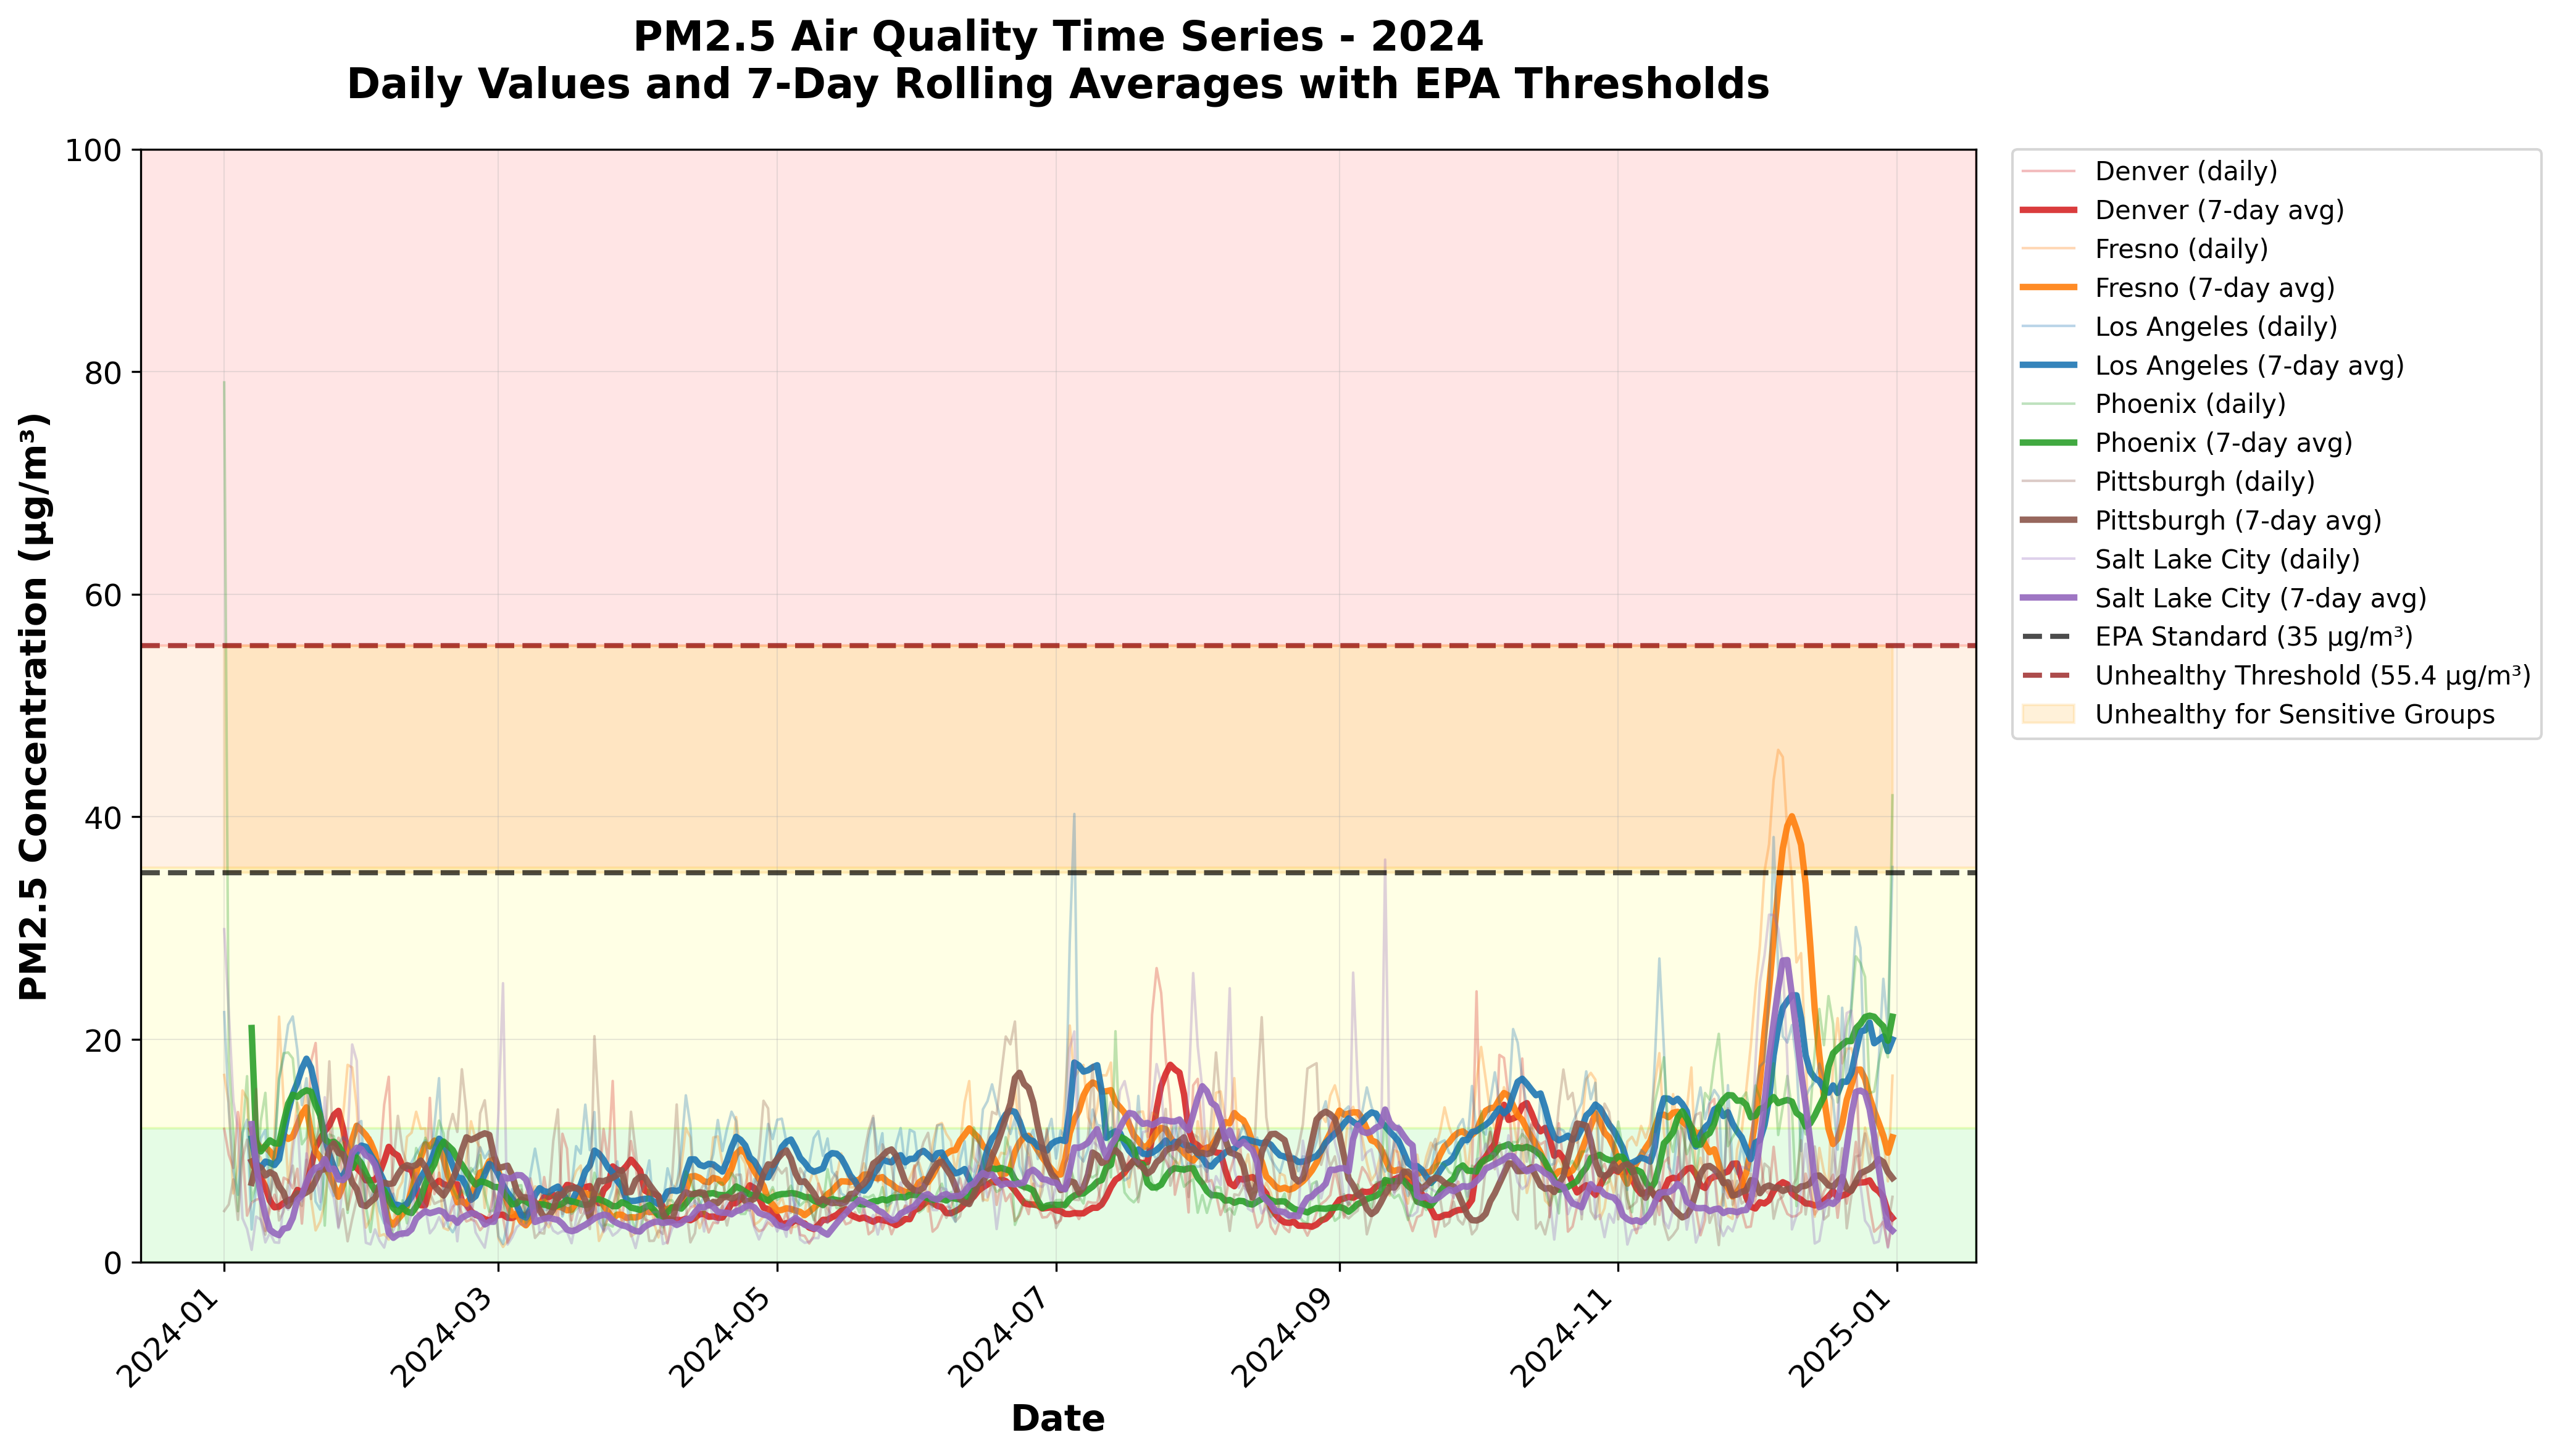

In [638]:
# Add scripts directory to path
sys.path.insert(0, 'scripts')

from plot_timeseries import plot_enhanced_timeseries

# Generate the time series plot
output_path = 'figures/timeseries_detailed.png'
plot_enhanced_timeseries(df, output_path)

# Display the generated figure
print("Time Series Analysis with Rolling Averages:\n")
display(Image(filename=output_path))

Figure saved to figures/pm25_distribution.png
PM2.5 Distribution Across All Cities:



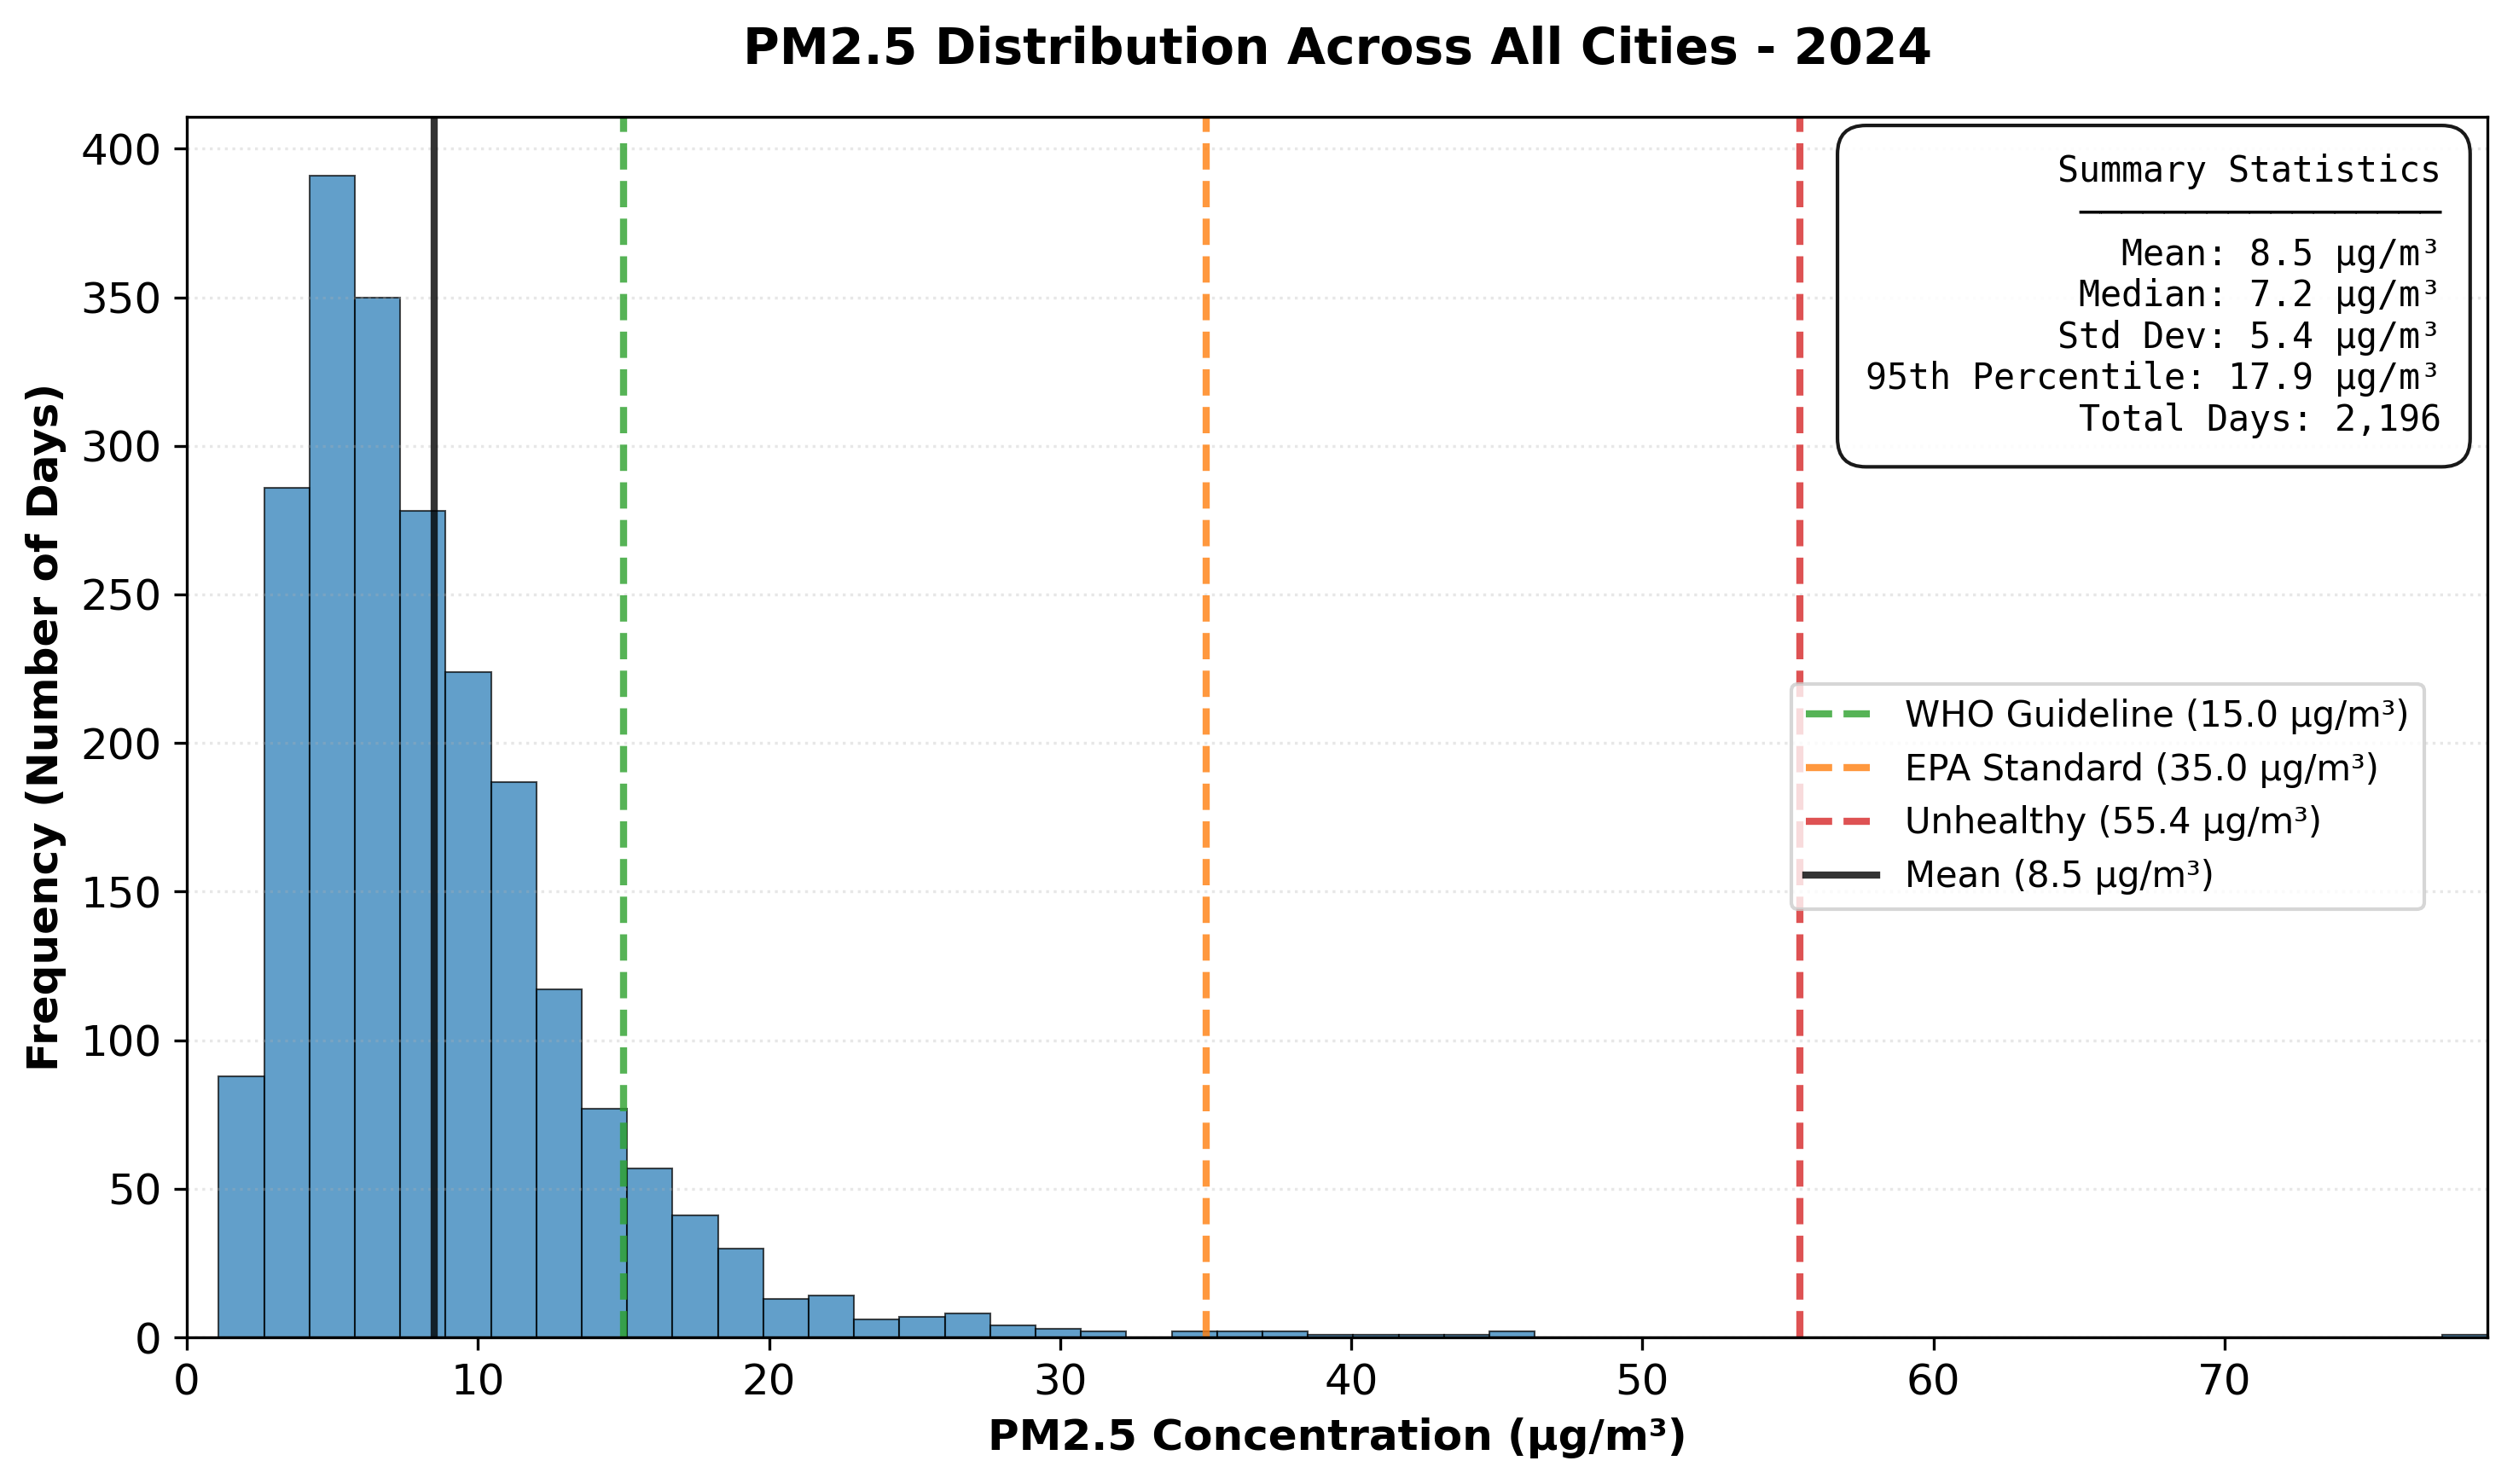

In [639]:
from plot_distribution import create_distribution_plot

# Generate the distribution plot
output_path = 'figures/pm25_distribution.png'
create_distribution_plot(df, output_path)

# Display the generated figure
print("PM2.5 Distribution Across All Cities:\n")
display(Image(filename=output_path))

The distribution shows that most days have PM2.5 levels well below the EPA 24-hour standard, but there's a right-skewed tail indicating occasional high pollution events. The majority of measurements fall in the "Good" to "Moderate" AQI categories.

### Extreme Event Comparison

The `plot_extremes.py` script creates a grouped bar chart comparing exceedance counts across cities using multiple threshold definitions:

Figure saved to figures/extreme_events.png
Figure saved to figures/extreme_events.png

=== Exceedance Summary ===
EPA Standard (>35 μg/m³):
  Denver: 0 days
  Fresno: 6 days
  Los Angeles: 3 days
  Phoenix: 2 days
  Pittsburgh: 0 days
  Salt Lake City: 1 days

95th Percentile (>17.9 μg/m³):
  Denver: 10 days
  Fresno: 21 days
  Los Angeles: 28 days
  Phoenix: 21 days
  Pittsburgh: 7 days
  Salt Lake City: 23 days
Extreme Event Comparison Across Cities:



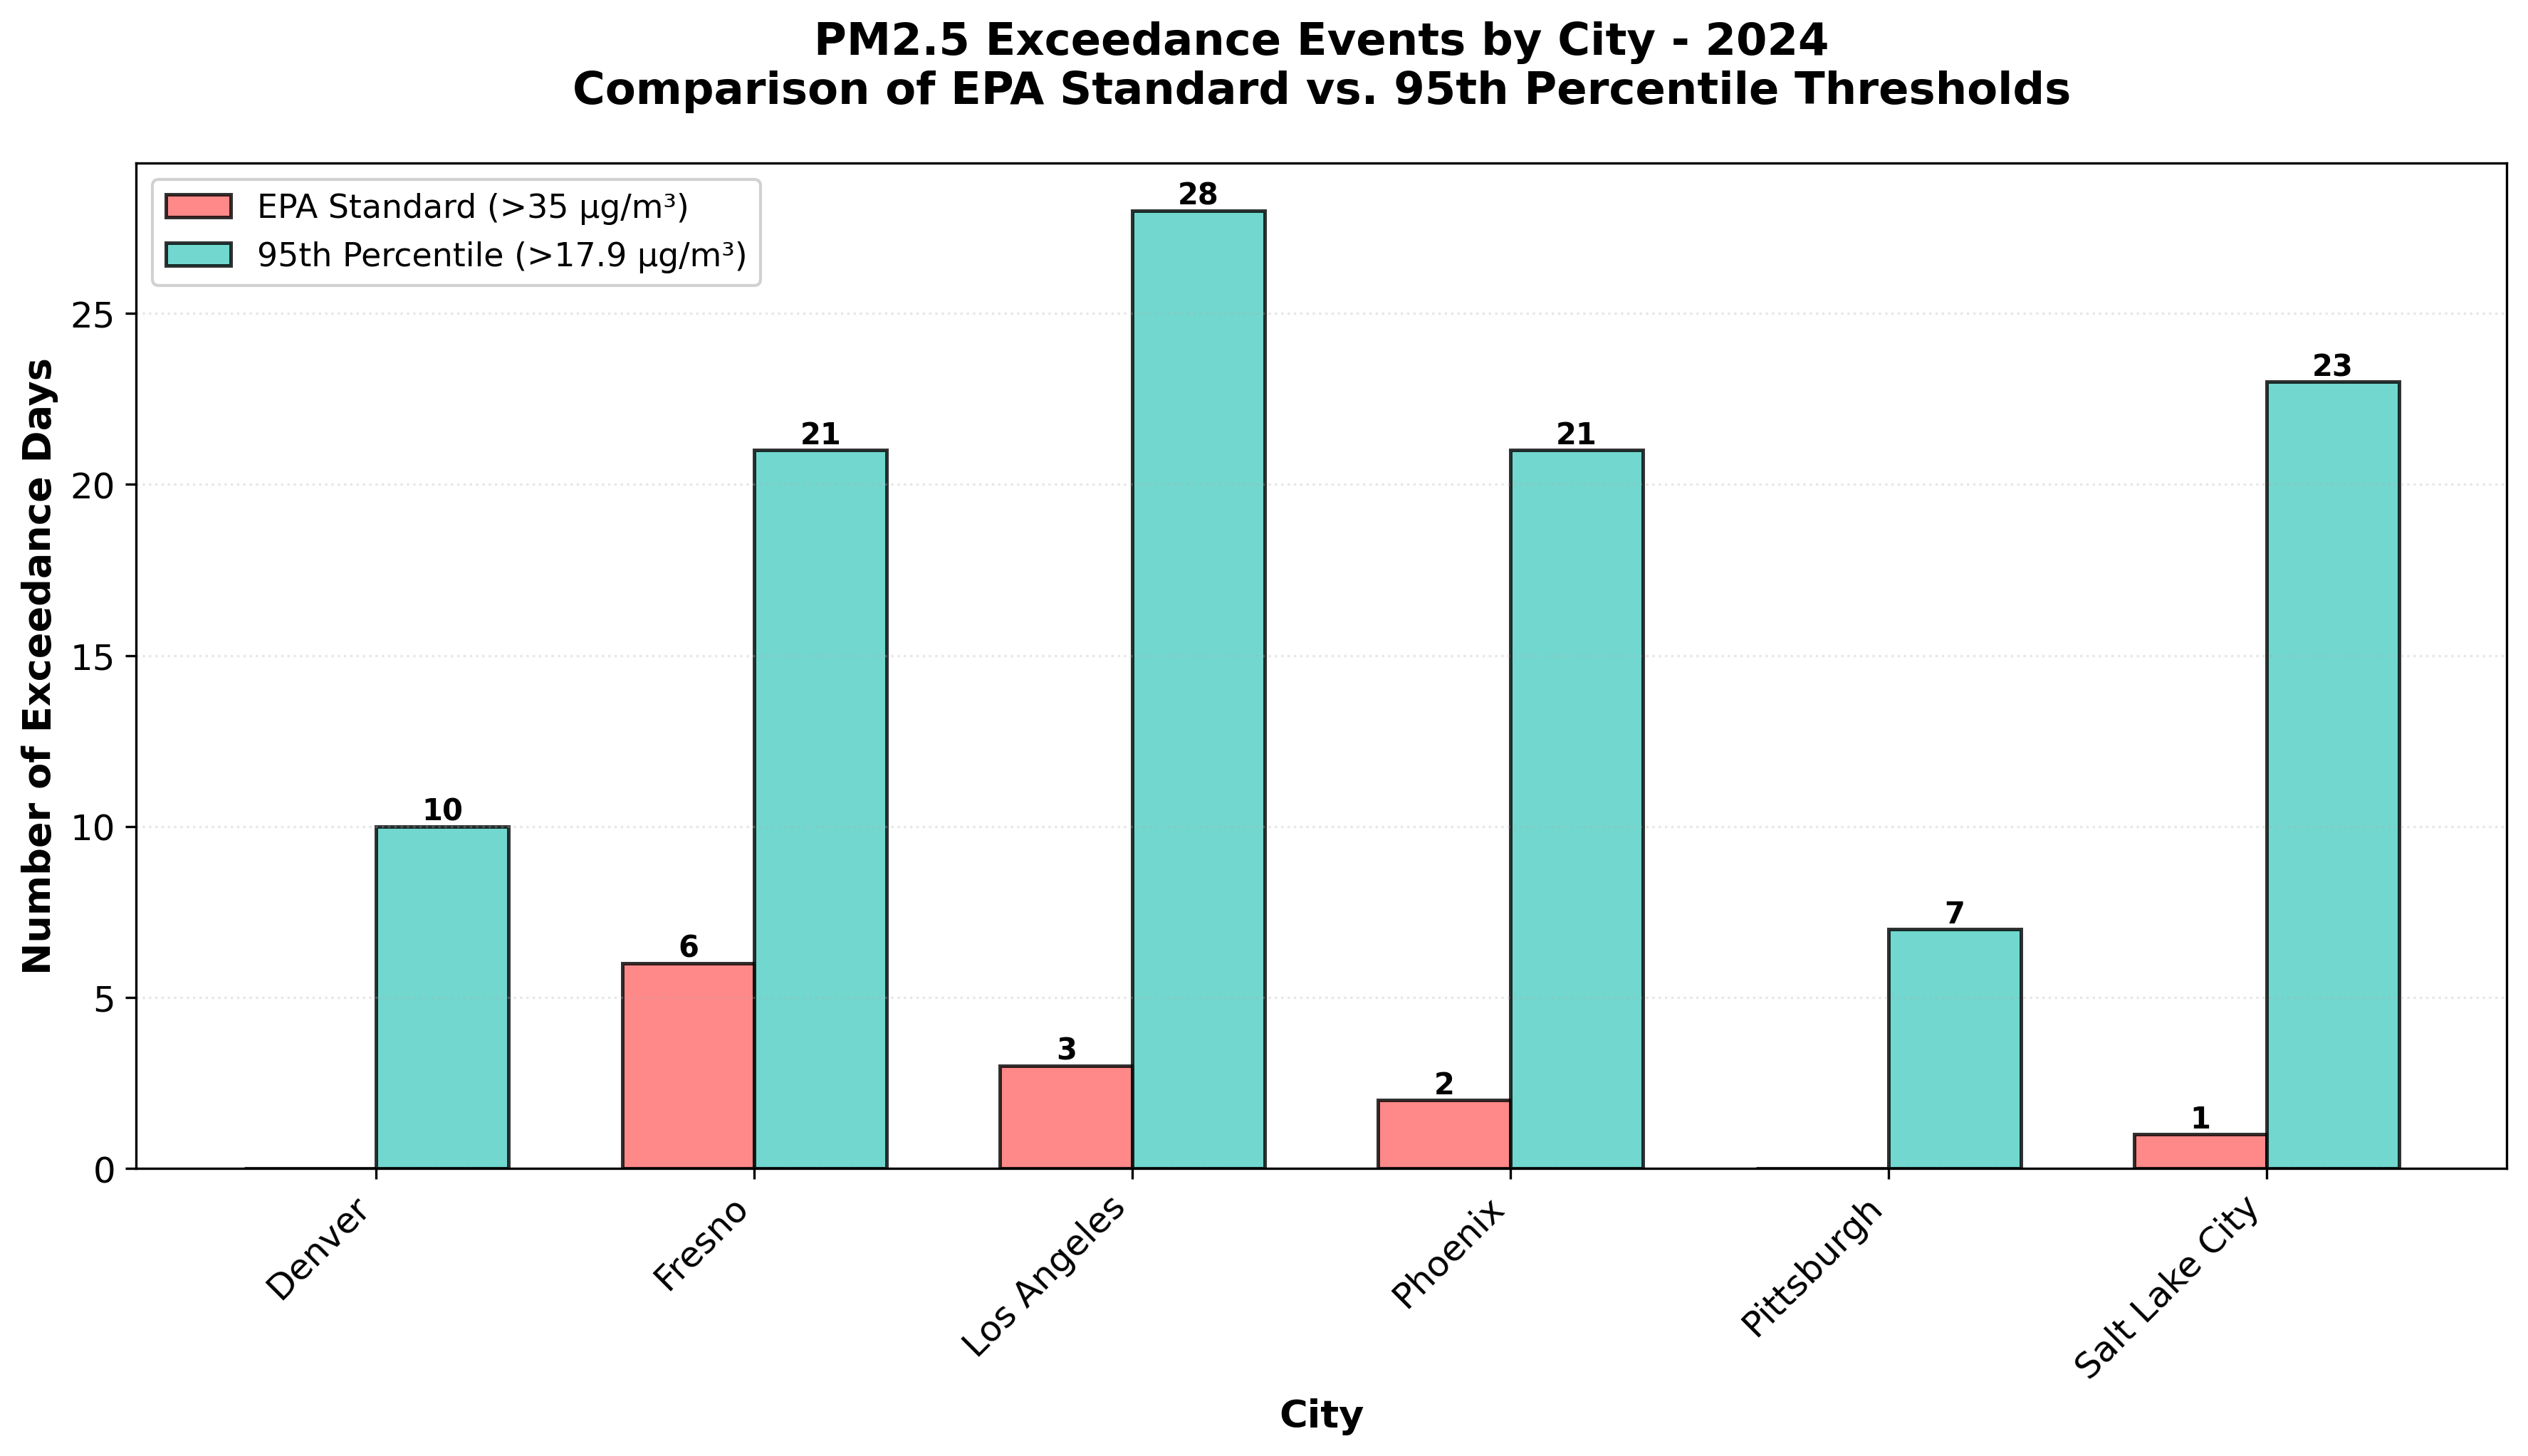

In [640]:
from plot_extremes import create_extremes_comparison

# Generate the extremes comparison plot
output_path = 'figures/extreme_events.png'
create_extremes_comparison(df, output_path)

# Display the generated figure
print("Extreme Event Comparison Across Cities:\n")
display(Image(filename=output_path))

This comparison highlights which cities experience more frequent extreme pollution events. The dual threshold approach (EPA standard vs. 95th percentile) helps distinguish between absolute and relative extremes.

### Statistical Summary Box Plots

The `plot_statistics.py` script creates a grid of box plots showing the PM2.5 distributions for each city:

Figure saved to figures/statistical_summary.png
Statistical Summary for All Cities:



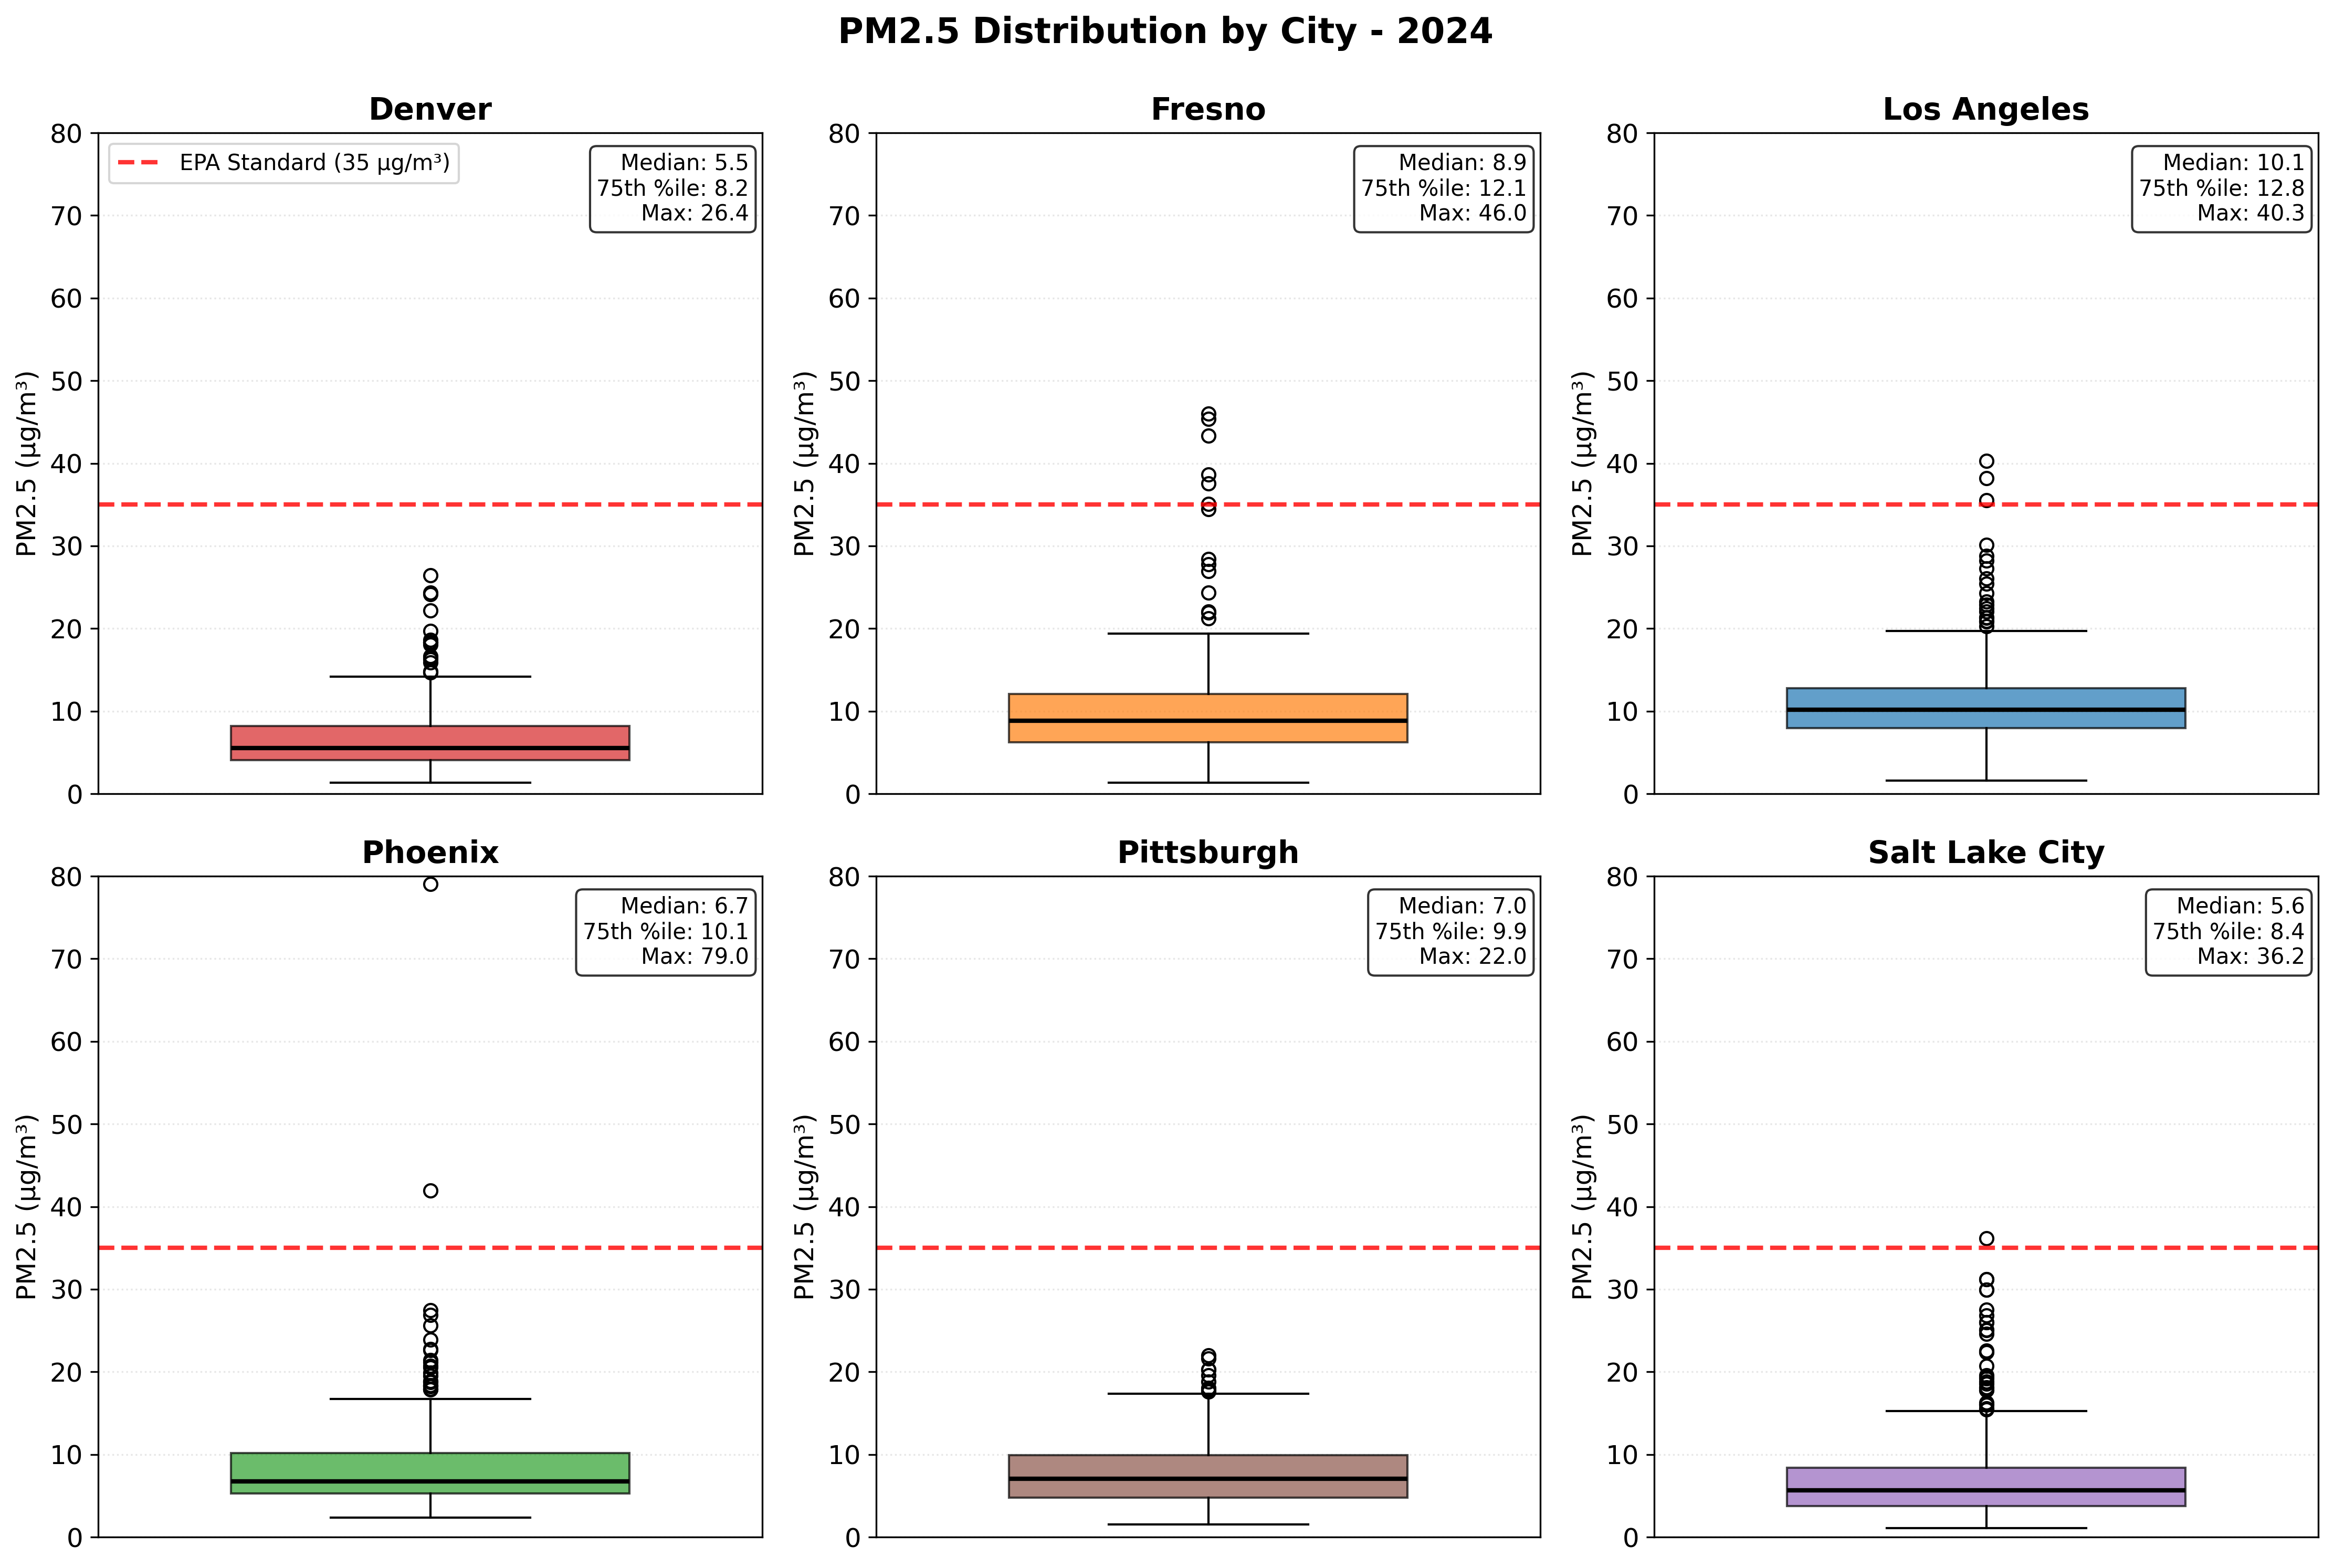

In [641]:
from plot_statistics import create_statistical_summary

# Generate the statistical summary plot
output_path = 'figures/statistical_summary.png'
create_statistical_summary(df, output_path)

# Display the generated figure
print("Statistical Summary for All Cities:\n")
display(Image(filename=output_path))

The box plots provide a clear comparison of the distribution characteristics across cities, including median values, interquartile ranges, and outliers. This makes it easy to identify which cities have the most variable air quality and which experience the most extreme events.